In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='2'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_3 共1个任务（四折交叉验证）

### 1. 49峰值测试

In [4]:
dfx = LoadMSData(root_path = root_path, data_path = 'data3/peaks_49.csv', t = False)
Y = np.zeros((117,2))                                             #将标签以独热编码存起来
for i in range (0,60):                                           #阳性60例
    Y[i,1] = 1                                                    #阳性标签为1
for i in range (60,117):                                         #阴性57例
    Y[i,0] = 1                                                    #阴性标签为0
y = Y.astype(int)

Y = np.zeros(117)                                                 #用于分层的标签
for i in range (0,60):                                           #阴性60例
    Y[i] = 1                                                    
for i in range (60,117):                                          #阳性57例
    Y[i] = 0
Y = Y.astype(int)

In [5]:
mp = AggMap(dfx, metric = 'euclidean')                          #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
#SaveMpOrX(data = mp, save_path = save_path, data_num = 'data3', file_type = 'aggmap', file_name = 'aggmap_49peaks.mp')

2024-01-11 10:23:18,362 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-11 10:23:18,375 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 49/49 [00:00<00:00, 177.56it/s]


2024-01-11 10:23:20,514 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-11 10:23:31,814 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-11 10:23:31,848 - INFO - [bidd-aggmap] - Finished


In [6]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 117/117 [00:13<00:00,  8.42it/s]


In [ ]:
#代码复现
outer = StratifiedKFold(n_splits = 4,shuffle = True,random_state=2652124)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = AggMapNet.MultiClassEstimator(epochs=150,gpuid=3,conv1_kernel_size=3)         #显存不足记得更改gpu
    history = clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 4

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.0, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 24, 48], verbose=0)
Auc =  0.8666666666666667
Acc =  0.8666666666666667
f1_score =  0.8666666666666667
average_precision =  0.8666666666666667
recall_score =  0.8666666666666667


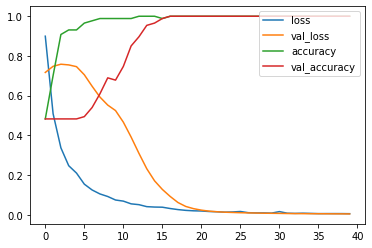

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.0, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 24, 48], verbose=0)
Auc =  0.8595238095238095
Acc =  0.8620689655172413
f1_score =  0.8620689655172413
average_precision =  0.8620689655172413
recall_score =  0.8620689655172413


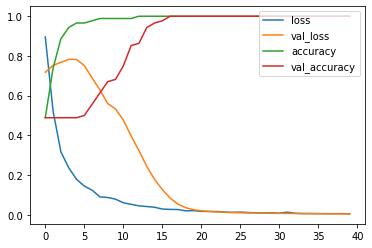

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.0, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 24, 48], verbose=0)
Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


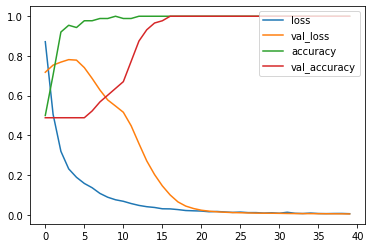

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.0, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 24, 48], verbose=0)
Auc =  0.9333333333333333
Acc =  0.9310344827586207
f1_score =  0.9310344827586207
average_precision =  0.9310344827586207
recall_score =  0.9310344827586207


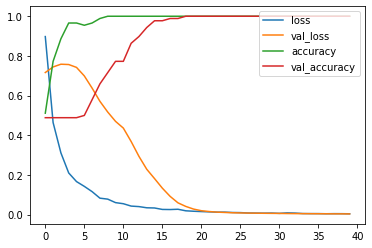

0.9149425287356322

In [33]:
#三核 四折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 4,shuffle = True,random_state=36)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=40,gpuid=2,verbose=0,printOrNot=True)
    clf.fit(train_X, train_Y, X_val = train_X, y_val = train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 4

In [28]:
for ran_rate in range(50):
    #三核 四折交叉验证最佳结果
    outer = StratifiedKFold(n_splits = 4,shuffle = True,random_state=ran_rate)      #数据集进行分层交叉验证划分训练集和测试集
    Sum_acc = 0
    for train_index,test_index in outer.split(X,Y):
        train_X,test_X = X[train_index],X[test_index]
        train_Y,test_y = y[train_index],Y[test_index]

        clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=35,gpuid=2,verbose=0,printOrNot=False)
        clf.fit(train_X, train_Y)

        y_pred = clf.predict(test_X)
        #MADLINet Test Metrics
        auc = roc_auc_score(test_y, y_pred)
        acc = accuracy_score(test_y,y_pred)
        rec = recall_score(test_y, y_pred,average="micro")
        f1 = f1_score(test_y, y_pred,average="micro")
        pr = precision_score(test_y, y_pred,average="micro")
#         print("Auc = ",auc)
#         print("Acc = ",acc)
#         print("f1_score = ",f1)
#         print("average_precision = ",pr)
#         print("recall_score = ",rec)
        Sum_acc += acc
        #plot train curve
        #PlotCurve(clf.history)
    print(f'{ran_rate} acc is {Sum_acc / 4}')

0 acc is 0.8885057471264368
1 acc is 0.889080459770115
2 acc is 0.8905172413793103
3 acc is 0.8887931034482759
4 acc is 0.8798850574712644
5 acc is 0.8635057471264367
6 acc is 0.9060344827586206
7 acc is 0.8896551724137931
8 acc is 0.8887931034482758
9 acc is 0.8974137931034483
10 acc is 0.8804597701149425
11 acc is 0.871551724137931
12 acc is 0.889367816091954
13 acc is 0.8882183908045977
14 acc is 0.8977011494252873
15 acc is 0.8807471264367815
16 acc is 0.9060344827586206
17 acc is 0.8807471264367817
18 acc is 0.9063218390804597
19 acc is 0.8724137931034484
20 acc is 0.8977011494252873
21 acc is 0.8968390804597701
22 acc is 0.8882183908045976
23 acc is 0.8635057471264367
24 acc is 0.8979885057471264
25 acc is 0.889080459770115
26 acc is 0.8724137931034482
27 acc is 0.8801724137931033
28 acc is 0.8721264367816092
29 acc is 0.889367816091954
30 acc is 0.8974137931034483
31 acc is 0.9066091954022989
32 acc is 0.8887931034482758
33 acc is 0.8626436781609195
34 acc is 0.8718390804597701


Auc =  0.9
Acc =  0.9
f1_score =  0.9
average_precision =  0.9
recall_score =  0.9


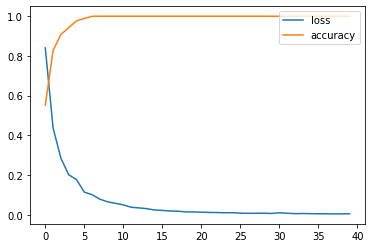

Auc =  0.8952380952380953
Acc =  0.896551724137931
f1_score =  0.896551724137931
average_precision =  0.896551724137931
recall_score =  0.896551724137931


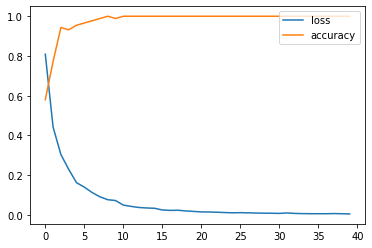

Auc =  0.9333333333333333
Acc =  0.9310344827586207
f1_score =  0.9310344827586207
average_precision =  0.9310344827586207
recall_score =  0.9310344827586207


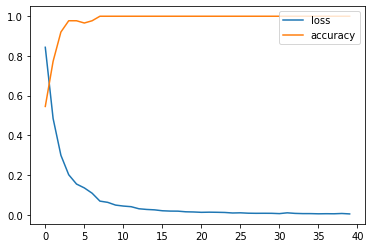

Auc =  0.8976190476190476
Acc =  0.896551724137931
f1_score =  0.896551724137931
average_precision =  0.896551724137931
recall_score =  0.896551724137931


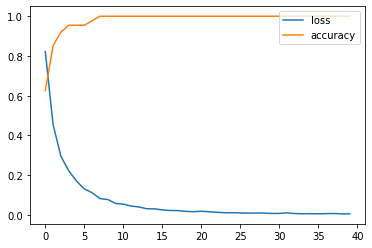

0.9060344827586206

In [62]:
#三核 原来结果90.6%
outer = StratifiedKFold(n_splits = 4,shuffle = True,random_state=2652124)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    tf.compat.v1.set_random_seed(32)
    clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',dense_layers=[128,64], dropout = 0)
    opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    history = clf.fit(train_X, train_Y, batch_size=64, epochs=40, verbose=0)

    probs = clf.predict(test_X)
    y_pred = np.argmax(probs, axis=1)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(history)
Sum_acc / 4

In [34]:
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data3', file_type = 'aggmap', file_name = 'aggmap_49peaks.mp')

### 2. 不同minfre参数测试

In [48]:
dfx = LoadMSData(root_path = root_path, data_path = 'data3/peaks_all.csv', t = False)
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [53]:
mp = load('/mnt/lzyt/SmallSamples/data3/aggmap/aggmap_49peaks.mp')
dfx = LoadMSData(root_path = root_path, data_path = 'data3/peaks_49.csv', t = False)

In [54]:
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')

100%|##########| 117/117 [00:01<00:00, 58.98it/s]


MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.2, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 24, 48], verbose=0)
Auc =  0.8666666666666667
Acc =  0.8666666666666667
f1_score =  0.8666666666666667
average_precision =  0.8666666666666667
recall_score =  0.8666666666666667


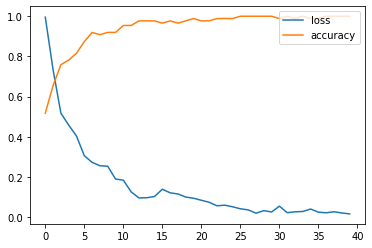

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.2, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 24, 48], verbose=0)
Auc =  0.8952380952380953
Acc =  0.896551724137931
f1_score =  0.896551724137931
average_precision =  0.896551724137931
recall_score =  0.896551724137931


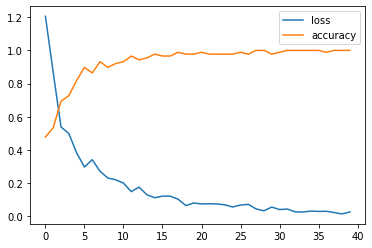

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.2, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 24, 48], verbose=0)
Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


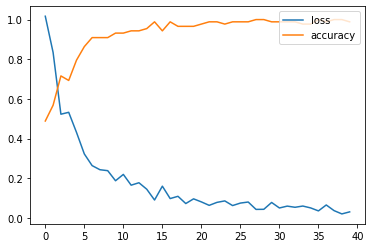

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.2, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 24, 48], verbose=0)
Auc =  0.9333333333333333
Acc =  0.9310344827586207
f1_score =  0.9310344827586207
average_precision =  0.9310344827586207
recall_score =  0.9310344827586207


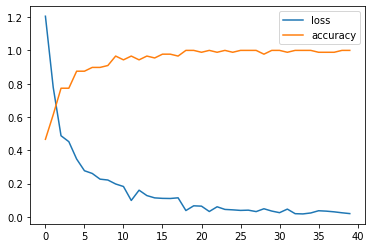

0.9235632183908046

In [63]:
#三核 四折交叉验证最佳结果 91.49%
outer = StratifiedKFold(n_splits = 4,shuffle = True,random_state=36)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=40,gpuid=2,verbose=0,dropout=0.2,printOrNot=True)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 4

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.0, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 36, 36], verbose=0)
Auc =  0.9333333333333333
Acc =  0.9333333333333333
f1_score =  0.9333333333333333
average_precision =  0.9333333333333333
recall_score =  0.9333333333333333


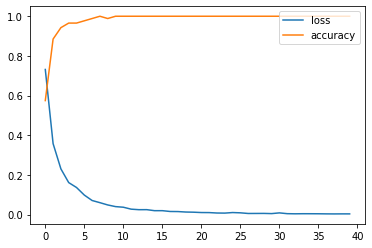

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.0, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 36, 36], verbose=0)
Auc =  0.8976190476190476
Acc =  0.896551724137931
f1_score =  0.896551724137931
average_precision =  0.896551724137931
recall_score =  0.896551724137931


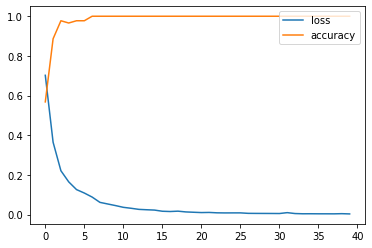

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.0, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 36, 36], verbose=0)
Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


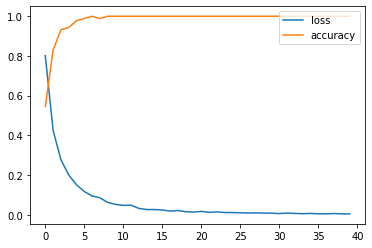

MultiClassEstimator(batch_size=64, dense_avf='relu', dense_layers=[128, 64],
                    dropout=0.0, early_stop=False, epochs=40, gpuid='2',
                    kernel_block='MK', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='MALDINet MultiClass Estimator', patience=10000,
                    random_state=32, units=[12, 36, 36], verbose=0)
Auc =  0.8642857142857143
Acc =  0.8620689655172413
f1_score =  0.8620689655172413
average_precision =  0.8620689655172413
recall_score =  0.8620689655172413


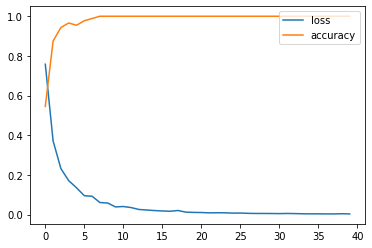

0.9229885057471263

In [106]:
#三核 四折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 4,shuffle = True,random_state=36)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=64,epochs=40,gpuid=2,verbose=0,
                                       loss='categorical_crossentropy',units=[12, 36, 36],printOrNot=True)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 4